In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
Data_set = pd.read_csv('challenge_data/Data_set.csv')
Test_set = pd.read_csv('challenge_data/Test_set.csv')

In [3]:
X = Data_set.iloc[:,2:]
y = Data_set.iloc[:,1]
X_test = Test_set.iloc[:,2:]
X = X.fillna(0)
X_test = X_test.fillna(0)

In [4]:
def str_to_int(train, test):
    train = train.fillna(0)
    test = test.fillna(0)
    idx = 0
    for item in train.unique():
        train.loc[train==item] = idx
        test.loc[train==item] = idx
        idx += 1
    return train, test

In [5]:
string_column = []
for i,col in enumerate(X.columns):
    if X[col].dtype != np.float64 and X[col].dtype != np.int64:
        string_column.append(i)
        X[col], X_test[col] = str_to_int(X[col], X_test[col])

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
# Create classifiers
lr = LogisticRegression(n_jobs=-1, class_weight={0:1,1:20})
gnb = GaussianNB()
svc = LinearSVC(C=1.0, class_weight={0:1,1:20})
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight={0:100,1:1})
bg = BaggingClassifier(n_jobs=-1)

('Logistic', array([ 0.89936183,  0.23846154]))
[[15925   290]
 [ 3274   558]]
('Naive Bayes', array([ 0.95181996,  0.1842576 ]))
[[18017   642]
 [ 1182   206]]
('Support Vector Classification', array([ 0.96238961,  0.09159348]))
[[18526   775]
 [  673    73]]
('Random Forest', array([ 0.97926267,  0.21663443]))
[[19125   736]
 [   74   112]]
('Bagging Classifier', array([ 0.97806253,  0.20297952]))
[[19082   739]
 [  117   109]]


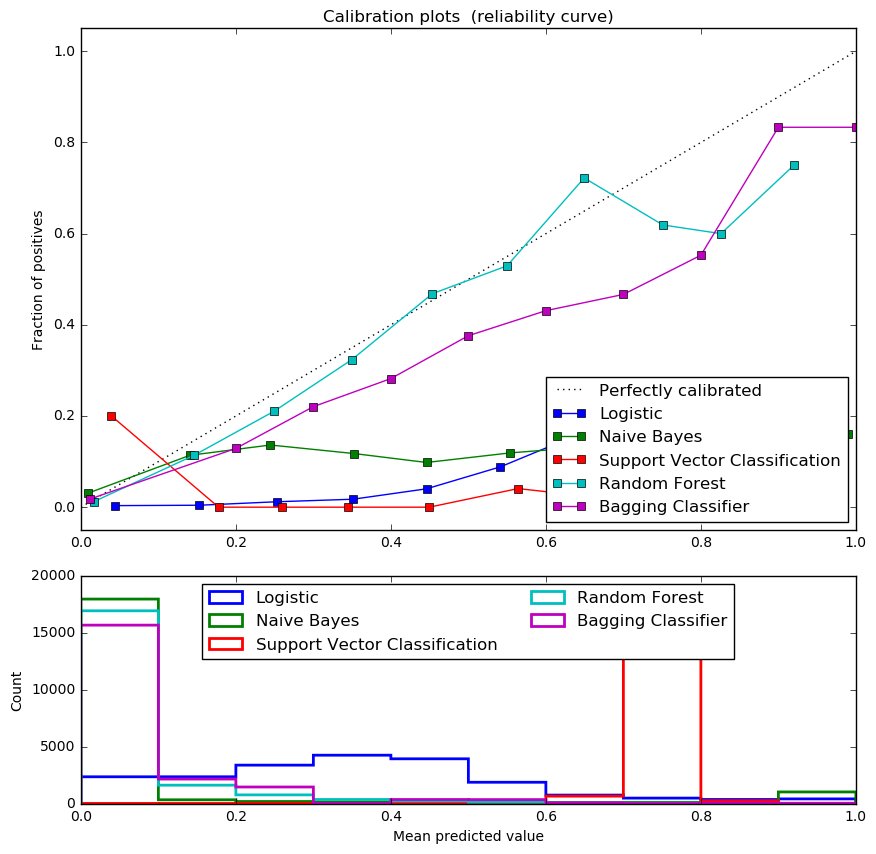

In [18]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest'),
                  (bg, 'Bagging Classifier')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_val)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_val)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_val, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)
    
    print(name, f1_score(clf.predict(X_val), y_val, average=None))
    print(confusion_matrix(clf.predict(X_val), y_val))

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.show()